In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmium
import re
import warnings
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm
from shapely.ops import split, snap, unary_union, polygonize, linemerge
from shapely.geometry import MultiPolygon, Polygon, MultiLineString, LineString, Point, MultiPoint, box, polygon
from pyproj import Transformer

In [76]:
class RelationHandler(osmium.SimpleHandler):

    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.count_bid = 0
        self.area_to_bid = {}
        self.relation_to_bid = {}

    def get_area_to_bid(self):
        return self.area_to_bid
    
    def get_relation_to_bid(self):
        return self.relation_to_bid
        
    def relation(self, r):
        tags = dict(r.tags)
        
        # Qualifiers
        if not ('building' in tags or 'building:part' in tags or tags.get('type') == 'building'):
            return
        # Disqualifiers
        if (tags.get('location') == 'underground' or 'bridge' in tags):
            return
        
        if r.id not in self.relation_to_bid:
            self.relation_to_bid[r.id] = self.count_bid # Add the relation_ids as count bid: map[11571471] = 0, map[11271912] = 1, ...
            self.count_bid +=1
        
        for member in r.members:
            if member.ref not in self.area_to_bid:
                self.area_to_bid[member.ref] = self.relation_to_bid[r.id] # map the ways of that relation_id as same count -> map[121314] = 0 (part of 11571471)

class AreaHandler(osmium.SimpleHandler):

    def __init__(self, area_to_bid, relation_to_bid):
        osmium.SimpleHandler.__init__(self)
        self.id = []
        self.orig_id = []
        self.building_id = []
        self.tag = []
        self.geometry = []
        self.wkbfab = osmium.geom.WKBFactory()
        
        self.area_to_bid = area_to_bid
        self.relation_to_bid = relation_to_bid
        self.max_bid = max(self.area_to_bid, key=area_to_bid.get)
        self.max_bid = max(self.max_bid,max(self.relation_to_bid, key=relation_to_bid.get))

    def get_gdf(self):
        geometry = gpd.GeoSeries.from_wkb(self.geometry, crs='epsg:4326')
        tag = pd.Series(self.tag)
        iid = pd.Series(self.id, dtype='UInt64')
        orig_id = pd.Series(self.orig_id, dtype='UInt64')
        building_id = pd.Series(self.building_id, dtype='UInt64')
        
        return gpd.GeoDataFrame({
            'id': iid,
            'orig_id': orig_id,
            'building_id': building_id,
            'geometry': geometry,
            'tags': tag
        }, index=geometry.index)
    
    def area(self, a):
        tags = dict(a.tags)
        iid = int(a.id)
        orig_id = int(a.orig_id())
        
        # Qualifiers
        if not ('building' in tags or 'building:part' in tags or tags.get('type') == 'building'):
            return
        # Disqualifiers
        if (tags.get('location') == 'underground' or 'bridge' in tags):
            return
        
        if orig_id in self.area_to_bid:
            # print(orig_id)
            building_id = self.area_to_bid[orig_id]
        elif orig_id in self.relation_to_bid:
            building_id = self.relation_to_bid[orig_id]
        else:
            building_id = self.max_bid
            self.max_bid+=1
        
        try:
            poly = self.wkbfab.create_multipolygon(a)
            self.geometry.append(poly)
            self.tag.append(tags)
            self.id.append(iid)
            self.orig_id.append(orig_id)
            self.building_id.append(building_id)
            
        except Exception as e:
            print(e)
            print(a)

In [77]:
h = RelationHandler()
h.apply_file('data/osm/rec.osm.pbf', locations=True)
area_to_bid = h.get_area_to_bid()
relation_to_bid = h.get_relation_to_bid()

In [78]:
h = AreaHandler(area_to_bid, relation_to_bid)
h.apply_file('data/osm/rec.osm.pbf', locations=True)

In [79]:
gdf = h.get_gdf()
gdf = gdf.to_crs('epsg:3395')
gdf

,id,orig_id,building_id,geometry,tags
0,103632422,51816211,372613649,"MULTIPOLYGON (((-3881901.401 -894700.846, -388...","{'addr:housename': 'Armazém 12', 'building': '..."
1,103632432,51816216,372613650,"MULTIPOLYGON (((-3882153.929 -894808.150, -388...","{'building': 'yes', 'building:levels': '5', 'n..."
2,103632434,51816217,372613651,"MULTIPOLYGON (((-3882170.894 -894729.875, -388...","{'addr:city': 'Recife', 'addr:housenumber': '3..."
3,103632436,51816218,372613652,"MULTIPOLYGON (((-3882008.257 -894818.951, -388...","{'addr:city': 'Recife', 'addr:housenumber': '1..."
4,103632440,51816220,372613653,"MULTIPOLYGON (((-3881952.931 -894798.567, -388...","{'addr:housename': 'Armazém 13', 'building': '..."
...,...,...,...,...,...
140735,2141551196,1070775598,372753992,"MULTIPOLYGON (((-3886741.183 -893286.228, -388...","{'addr:city': 'Recife', 'addr:housenumber': '1..."
140736,2142328828,1071164414,372753993,"MULTIPOLYGON (((-3884965.670 -882385.388, -388...","{'addr:street': 'Rua Trinta e Nove', 'amenity'..."
140737,2143656474,1071828237,372753994,"MULTIPOLYGON (((-3892679.087 -904817.115, -389...",{'building': 'warehouse'}
140738,26060041,13030020,339,"MULTIPOLYGON (((-3884610.049 -897014.924, -388...",{'alt_name': 'Empresarial Riomar Trade Center ...


<AxesSubplot:>

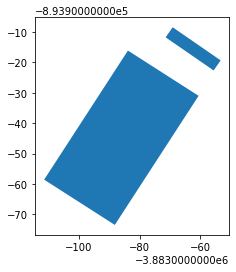

In [82]:
gdf[gdf['orig_id'] == 7951360].plot()

<AxesSubplot:>

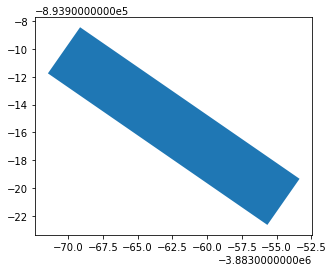

In [83]:
gdf[gdf['orig_id'] == 662611641].plot()

In [39]:
gdf[gdf['building_id'] == 341]

,id,orig_id,building_id,geometry,min_height,height,tags
140739,26060045,13030022,341,"MULTIPOLYGON (((-3884648.499 -897070.964, -388...",0.0,35.0,"{'addr:city': 'Recife', 'addr:housenumber': '2..."


In [7]:
way_id = gdf['orig_id'].to_list()

In [10]:
latest_osm_way_id = pd.read_csv('data/all-building-features.csv', index_col = 0)['id'].to_list()

C:\Users\qshah\AppData\Local\Temp\ipykernel_11096\289137431.py:1: DtypeWarning: Columns (5,7,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,46,48,49,50,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,187,188,189,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256) have mixed types. Specify dtype option on import

<AxesSubplot:>

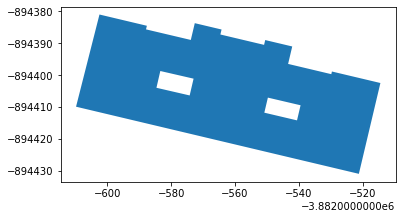

In [25]:
gdf[gdf.orig_id == 5535458].plot()

In [26]:
print(gdf[gdf.orig_id == 5535458].geometry.iloc[0])

MULTIPOLYGON (((-3882609.860544179 -894409.9530229795, -3882521.172305864 -894431.0070866684, -3882514.415212773 -894402.525464422, -3882529.6214552163 -894398.9177935686, -3882529.81069835 -894399.755488013, -3882543.3582803793 -894396.5387414319, -3882542.0669742865 -894391.0658050729, -3882550.538387535 -894389.0553388244, -3882550.894609906 -894390.5631885024, -3882564.598039223 -894387.3129348154, -3882564.230684903 -894385.7492389678, -3882572.6241745087 -894383.7611114694, -3882573.870952806 -894389.0218310542, -3882587.9194725435 -894385.7045619445, -3882587.652305766 -894384.5764671181, -3882602.5134577877 -894381.0469824992, -3882609.860544179 -894409.9530229795), (-3882584.6466795146 -894404.0221452949, -3882583.433297065 -894398.7614239404, -3882573.002660778 -894401.1628147153, -3882574.2271751757 -894406.4235363528, -3882584.6466795146 -894404.0221452949), (-3882550.8166862624 -894411.8294590218, -3882549.703491355 -894407.1048612815, -3882539.4509662525 -894409.506252505

In [ ]:
# relation are completely excluded which should not be the case!!
